In [1]:
# Set up a chain rule to calculate the loss function @ saturation w/out propagating derivatives through saturation solver
# This was done in the Language of Molecules paper.

# 1_differentiable_saft works when no solvers are involved, i.e. for properties specified with a given (V, T)
# if, instead, we want to solve for saturation conditions, then I have the old problem of 

In [2]:
import Pkg; Pkg.activate(".")

using Revise
using Clapeyron
includet("./saftvrmienn.jl")
# These are functions we're going to overload for SAFTVRMieNN
import Clapeyron: a_res, saturation_pressure, pressure

using Flux
using Plots
using ForwardDiff, DiffResults

using Zygote, ChainRulesCore
using ImplicitDifferentiation

using CSV, DataFrames
using MLUtils
using RDKitMinimalLib 
using Statistics

  Activating project at `/mnt/data/code/SAFT_ML`


In [3]:
X = [16.04, 1.0, 3.737, 6.0, 12.504, 152.58]
T = 100.0

X = [114.14099884033203, 1.6983753442764282, 7.993192672729492, 8.710663437843323, 18.967856884002686, 248.48995435237885]
# T = 345.38165

p = saturation_pressure_NN(X, T)
∂p∂X = Zygote.gradient(X -> saturation_pressure_NN(X, T), X)
∂p∂T = Zygote.gradient(T -> saturation_pressure_NN(X, T), T)
@show p
@show ∂p∂X, ∂p∂T;

p = 16.267432682904257
(∂p∂X, ∂p∂T) = 

(([-0.0, -109.93750954832122, -6.1054825082882065, 21.530979767241124, 4.416594844872492, -1.3639866231328097],), (3.5520440640281374,))


In [4]:
# Create training & validation data
df = CSV.read("./pcpsaft_params/SI_pcp-saft_parameters.csv", DataFrame, header=1)
filter!(row -> occursin("Alkane", row.family), df)
mol_data = zip(df.common_name, df.isomeric_smiles, df.molarweight)
@info "generating data for $(length(mol_data)) molecules"

function make_fingerprint(s::String)::Vector{Float32}
    mol = get_mol(s)
    @assert !isnothing(mol)

    fp = []
    fp_details = Dict{String,Any}("nBits" => 512, "radius" => 4)
    fp_str = get_morgan_fp(mol, fp_details)
    append!(fp, [parse(Float32, string(c)) for c in fp_str])

    desc = get_descriptors(mol)
    relevant_keys = [
        "CrippenClogP",
        "NumHeavyAtoms",
        "amw",
        "FractionCSP3",
    ]
    relevant_desc = [desc[k] for k in relevant_keys]
    append!(fp, last.(relevant_desc))

    return fp
end

T = Float32
X_data = Vector{Tuple{Vector{T},T,T}}([])
Y_data = Vector{Vector{T}}()

n = 50
for (name, smiles, Mw) in mol_data
    saft_model = PPCSAFT([name])
    Tc, pc, Vc = crit_pure(saft_model)

    fp = make_fingerprint(smiles)
    append!(fp, Mw)

    T_range = range(0.5 * Tc, 0.975 * Tc, n)
    for T in T_range
        (p₀, V_vec...) = saturation_pressure(saft_model, T)
        push!(X_data, (fp, T, Mw))
        push!(Y_data, Float32[p₀])
    end
end

# Shuffle all samples into a random order
# Package into data loaders
# batchsize = 10
# train_data = DataLoader((X_data, y_data), batchsize=batchsize, shuffle=true)
#* shuffle=true randomises observation order every iteration

#* Remove zero columns from fingerprints
# Identify Zero Columns
num_cols = length(X_data[1][1])
zero_cols = trues(num_cols)
for (vec, _, _) in X_data
    zero_cols .&= (vec .== 0)
end

# Create a Mask
keep_cols = .!zero_cols

# Apply Mask
X_data = [(vec[keep_cols], val1, val2) for (vec, val1, val2) in X_data]

train_data, test_data = splitobs((X_data, Y_data), at=0.8, shuffle = true)

train_loader = DataLoader(train_data, batchsize=32, shuffle=true)
test_loader = DataLoader(test_data, batchsize=32, shuffle=false)

┌ Info: generating data for 80 molecules
└ @ Main /mnt/data/code/SAFT_ML/6_sat_solver_NN.ipynb:5


25-element DataLoader(::Tuple{SubArray{Tuple{Vector{Float32}, Float32, Float32}, 1, Vector{Tuple{Vector{Float32}, Float32, Float32}}, Tuple{Vector{Int64}}, false}, SubArray{Vector{Float32}, 1, Vector{Vector{Float32}}, Tuple{Vector{Int64}}, false}}, batchsize=32)
  with first element:
  (32-element Vector{Tuple{Vector{Float32}, Float32, Float32}}, 32-element Vector{Vector{Float32}},)

In [8]:
# Base NN architecture from "Fitting Error vs Parameter Performance"
nfeatures = length(X_data[1][1])
nout = 5
unbounded_model = Chain(
    Dense(nfeatures, 2048, selu),
    Dense(2048, 1024, selu),
    Dense(1024, 512, selu),
    Dense(512, 128, selu),
    Dense(128, 32, selu),
    Dense(32, nout, selu),
)
# model(x) = m, σ, λ_a, λ_r, ϵ

opt = ADAM(1e-3)

# Add constant bias to the model output
b = [
    3.0,
    3.5,
    7.0,
    12.5,
    250.0,
]
nn_model(x) = unbounded_model(x)/50.0 .+ b

# Training loop
@info "Beginning training..."
epochs = 50
epoch_percent_loss_vec = Float32[]
loss_vec = Float32[]
mean_loss_vec = Float32[]
mean_percent_loss_vec = Float32[]

loss_fn(X_batch, y_batch) = begin
    n = 0
    batch_loss = 0.0
    percent_error = 0.0
    for (X, y) in zip(X_batch, y_batch)
        fp, T, Mw = X
        y = y[1]

        X_pred = nn_model(fp)
        X_saft = vcat(Mw, X_pred)
        Tc = critical_temperature_NN(X_saft)
        if T < Tc
            ŷ = saturation_pressure_NN(X_saft, T)
            if !isnan(ŷ)
                n += 1
                batch_loss += ((ŷ - y) / y)^2
                percent_error += 100 * abs((ŷ - y) / y)
            end
        end
    end
    if n != 0
        batch_loss /= n
        percent_error /= n
    end
    batch_loss, percent_error
end

for epoch in 1:epochs
    epoch_loss_vec = Float32[]
    epoch_loss = 0.0

    for (X_batch, y_batch) in train_loader
        # @show loss_fn(X_batch, y_batch) 

        batch_loss = 0.0
        percent_error = 0.0
        grads = Zygote.gradient(Flux.params(unbounded_model)) do
            batch_loss, percent_error = loss_fn(X_batch, y_batch)
            percent_error
        end

        # Update model parameters
        Flux.update!(opt, Flux.params(unbounded_model), grads)

        append!(epoch_loss_vec, batch_loss)
        append!(epoch_percent_loss_vec, percent_error)
    end
    mean_loss = mean(epoch_loss_vec)
    mean_percent_loss = mean(epoch_percent_loss_vec)
    append!(loss_vec, epoch_loss_vec)
    append!(mean_loss_vec, mean_loss)
    append!(mean_percent_loss_vec, mean_percent_loss)

    # if epoch in [1, 2, 3, 4, 5, 10] || epoch % 5 == 0 || epoch == epochs || epoch % 2 == 0
    println("Epoch: $epoch, Loss: (μ=$mean_loss, σ=$(std(epoch_loss_vec))), Percent Error: $mean_percent_loss")
    # end
end

┌ Info: Beginning training...
└ @ Main /mnt/data/code/SAFT_ML/6_sat_solver_NN.ipynb:27


Epoch: 1, Loss: (μ=71.35296, σ=417.38248), Percent Error: 184.08777


Epoch: 2, Loss: (μ=0.99999, σ=4.4212916e-6), Percent Error: 142.04364


Epoch: 3, Loss: (μ=0.9999896, σ=4.599009e-6), Percent Error: 128.02893


Epoch: 4, Loss: (μ=0.99998933, σ=4.4760964e-6), Percent Error: 121.02156


Epoch: 5, Loss: (μ=0.99998856, σ=4.8766838e-6), Percent Error: 116.81715


Epoch: 6, Loss: (μ=0.999987, σ=5.4502943e-6), Percent Error: 114.01419


Epoch: 7, Loss: (μ=0.99997354, σ=5.06484e-5), Percent Error: 112.01198


Epoch: 8, Loss: (μ=0.9934108, σ=0.074945614), Percent Error: 110.44045


Epoch: 9, Loss: (μ=0.6448264, σ=0.5920592), Percent Error: 105.28033


Epoch: 10, Loss: (μ=1.1885074, σ=4.495989), Percent Error: 101.243805


Epoch: 11, Loss: (μ=0.73375833, σ=0.7059607), Percent Error: 98.43873


Epoch: 12, Loss: (μ=0.5847461, σ=0.4805339), Percent Error: 95.16965


Epoch: 13, Loss: (μ=0.710217, σ=0.42703426), Percent Error: 93.4197


Epoch: 14, Loss: (μ=0.6184689, σ=0.4198383), Percent Error: 91.4374


Epoch: 15, Loss: (μ=0.6463517, σ=0.9566935), Percent Error: 89.448685


Epoch: 16, Loss: (μ=0.5878609, σ=0.42434537), Percent Error: 87.79231


Epoch: 17, Loss: (μ=0.71606255, σ=1.9612975), Percent Error: 86.13824


Epoch: 18, Loss: (μ=0.6461348, σ=0.45942718), Percent Error: 85.00422


Epoch: 19, Loss: (μ=0.61902, σ=0.5558048), Percent Error: 83.78992


Epoch: 20, Loss: (μ=1.7437934, σ=12.4384775), Percent Error: 82.698265


Epoch: 21, Loss: (μ=0.46945232, σ=0.50103307), Percent Error: 80.99704


Epoch: 22, Loss: (μ=0.45953995, σ=0.5004099), Percent Error: 79.40521


Epoch: 23, Loss: (μ=0.4595832, σ=0.50045675), Percent Error: 77.95191


Epoch: 24, Loss: (μ=0.4495711, σ=0.49952596), Percent Error: 76.578026


Epoch: 25, Loss: (μ=0.41960084, σ=0.49557602), Percent Error: 75.1941


Epoch: 26, Loss: (μ=0.4495223, σ=0.49947184), Percent Error: 74.03186


Epoch: 27, Loss: (μ=0.42958337, σ=0.49709022), Percent Error: 72.88176


Epoch: 28, Loss: (μ=0.38954648, σ=0.48963955), Percent Error: 71.67089


Epoch: 29, Loss: (μ=0.4795021, σ=0.5015987), Percent Error: 70.85379


Epoch: 30, Loss: (μ=0.44947702, σ=0.49942252), Percent Error: 69.99111


Epoch: 31, Loss: (μ=0.42954236, σ=0.49704373), Percent Error: 69.119705


Epoch: 32, Loss: (μ=0.39957073, σ=0.4918402), Percent Error: 68.209045


Epoch: 33, Loss: (μ=0.43954334, σ=0.49837264), Percent Error: 67.47474


Epoch: 34, Loss: (μ=0.4795096, σ=0.50160664), Percent Error: 66.90123


Epoch: 35, Loss: (μ=0.43946224, σ=0.4982818), Percent Error: 66.24613


Epoch: 36, Loss: (μ=0.43945378, σ=0.49827218), Percent Error: 65.62743


Epoch: 37, Loss: (μ=0.4295267, σ=0.4970259), Percent Error: 65.015236


Epoch: 38, Loss: (μ=0.39946198, σ=0.49170777), Percent Error: 64.356224


Epoch: 39, Loss: (μ=0.4295011, σ=0.49699545), Percent Error: 63.808


Epoch: 40, Loss: (μ=0.44952422, σ=0.4994745), Percent Error: 63.337204


Epoch: 41, Loss: (μ=0.46953785, σ=0.50112283), Percent Error: 62.93817


Epoch: 42, Loss: (μ=0.49952924, σ=0.5020489), Percent Error: 62.629555


Epoch: 43, Loss: (μ=0.4795266, σ=0.50162387), Percent Error: 62.28878


Epoch: 44, Loss: (μ=0.44948003, σ=0.49942577), Percent Error: 61.895256


Epoch: 45, Loss: (μ=0.4235649, σ=0.4936433), Percent Error: 61.46676


Epoch: 46, Loss: (μ=0.46826404, σ=0.4999595), Percent Error: 61.150314


Epoch: 47, Loss: (μ=0.4196908, σ=0.4956814), Percent Error: 60.742535


Epoch: 48, Loss: (μ=0.4996305, σ=0.5021498), Percent Error: 60.518345


Epoch: 49, Loss: (μ=0.39975306, σ=0.49206382), Percent Error: 60.09935


Epoch: 50, Loss: (μ=0.34976834, σ=0.47905698), Percent Error: 59.59713


In [13]:
for epoch in 50:100
    epoch_loss_vec = Float32[]
    epoch_loss = 0.0

    for (X_batch, y_batch) in train_loader
        # @show loss_fn(X_batch, y_batch) 

        batch_loss = 0.0
        percent_error = 0.0
        grads = Zygote.gradient(Flux.params(unbounded_model)) do
            batch_loss, percent_error = loss_fn(X_batch, y_batch)
            percent_error
        end

        # Update model parameters
        Flux.update!(opt, Flux.params(unbounded_model), grads)

        append!(epoch_loss_vec, batch_loss)
        append!(epoch_percent_loss_vec, percent_error)
    end
    mean_loss = mean(epoch_loss_vec)
    mean_percent_loss = mean(epoch_percent_loss_vec)
    append!(loss_vec, epoch_loss_vec)
    append!(mean_loss_vec, mean_loss)
    append!(mean_percent_loss_vec, mean_percent_loss)

    # if epoch in [1, 2, 3, 4, 5, 10] || epoch % 5 == 0 || epoch == epochs || epoch % 2 == 0
    println("Epoch: $epoch, Loss: (μ=$mean_loss, σ=$(std(epoch_loss_vec))), Percent Error: $mean_percent_loss")
    # end
end

Epoch: 50, Loss: (μ=0.4496959, σ=0.4996638), Percent Error: 59.31061


Epoch: 51, Loss: (μ=0.41975698, σ=0.49575853), Percent Error: 58.97748


Epoch: 52, Loss: (μ=0.45968917, σ=0.5005715), Percent Error: 58.732334


Epoch: 53, Loss: (μ=0.3997085, σ=0.49200907), Percent Error: 58.385162


Epoch: 54, Loss: (μ=0.44970217, σ=0.49967033), Percent Error: 58.14153


Epoch: 55, Loss: (μ=0.37974724, σ=0.48750836), Percent Error: 57.781635


Epoch: 56, Loss: (μ=0.4297389, σ=0.49726838), Percent Error: 57.52207


Epoch: 57, Loss: (μ=0.42969626, σ=0.49721968), Percent Error: 57.271435


Epoch: 58, Loss: (μ=0.3497699, σ=0.47905862), Percent Error: 56.893757


Epoch: 59, Loss: (μ=0.37969765, σ=0.48744625), Percent Error: 56.578606


Epoch: 60, Loss: (μ=0.419699, σ=0.49569222), Percent Error: 56.339363


Epoch: 61, Loss: (μ=0.37970054, σ=0.48745006), Percent Error: 56.04333


Epoch: 62, Loss: (μ=0.41974685, σ=0.49574813), Percent Error: 55.820213


Epoch: 63, Loss: (μ=0.36984617, σ=0.48503554), Percent Error: 55.52603


Epoch: 64, Loss: (μ=0.3692711, σ=0.4843054), Percent Error: 55.240448


Epoch: 65, Loss: (μ=0.4097289, σ=0.4939856), Percent Error: 55.02448


Epoch: 66, Loss: (μ=0.3497925, σ=0.4790898), Percent Error: 54.72545


Epoch: 67, Loss: (μ=0.37969562, σ=0.48744383), Percent Error: 54.479263


Epoch: 68, Loss: (μ=0.41979408, σ=0.49580318), Percent Error: 54.298256


Epoch: 69, Loss: (μ=0.39974117, σ=0.49204963), Percent Error: 54.093807


Epoch: 70, Loss: (μ=0.41968796, σ=0.49567938), Percent Error: 53.92325


Epoch: 71, Loss: (μ=0.40968403, σ=0.49393317), Percent Error: 53.74354


Epoch: 72, Loss: (μ=0.37973216, σ=0.48749027), Percent Error: 53.5277


Epoch: 73, Loss: (μ=0.34973136, σ=0.479007), Percent Error: 53.277138


Epoch: 74, Loss: (μ=0.42967486, σ=0.49719688), Percent Error: 53.139896


Epoch: 75, Loss: (μ=0.35967115, σ=0.48198083), Percent Error: 52.914146


Epoch: 76, Loss: (μ=0.41966626, σ=0.49565417), Percent Error: 52.77219


Epoch: 77, Loss: (μ=0.36973843, σ=0.484896), Percent Error: 52.569817


Epoch: 78, Loss: (μ=0.36971313, σ=0.4848632), Percent Error: 52.372547


Epoch: 79, Loss: (μ=0.3296555, σ=0.472092), Percent Error: 52.130177


Epoch: 80, Loss: (μ=0.39818886, σ=0.49039173), Percent Error: 51.97926


Epoch: 81, Loss: (μ=0.40942723, σ=0.49363154), Percent Error: 51.845016


Epoch: 82, Loss: (μ=0.38984215, σ=0.49000943), Percent Error: 51.69016


Epoch: 83, Loss: (μ=0.36982524, σ=0.48500803), Percent Error: 51.51517


Epoch: 84, Loss: (μ=0.4296331, σ=0.4971476), Percent Error: 51.41478


Epoch: 85, Loss: (μ=0.42969677, σ=0.49722064), Percent Error: 51.31675


Epoch: 86, Loss: (μ=0.39957044, σ=0.49184045), Percent Error: 51.186428


Epoch: 87, Loss: (μ=0.37976852, σ=0.4875363), Percent Error: 51.03645


Epoch: 88, Loss: (μ=0.33971772, σ=0.47570258), Percent Error: 50.844875


Epoch: 89, Loss: (μ=0.35978976, σ=0.48213807), Percent Error: 50.679813


Epoch: 90, Loss: (μ=0.38970414, σ=0.4898381), Percent Error: 50.551296


Epoch: 91, Loss: (μ=0.37964723, σ=0.48738265), Percent Error: 50.414677


Epoch: 92, Loss: (μ=0.41963974, σ=0.49562344), Percent Error: 50.324005


Epoch: 93, Loss: (μ=0.36969495, σ=0.48483962), Percent Error: 50.1821


Epoch: 94, Loss: (μ=0.39968646, σ=0.49198332), Percent Error: 50.07475


Epoch: 95, Loss: (μ=0.42968202, σ=0.49720526), Percent Error: 50.000893


Epoch: 96, Loss: (μ=0.43955, σ=0.49838105), Percent Error: 49.938797


Epoch: 97, Loss: (μ=0.39947385, σ=0.49172458), Percent Error: 49.83711


Epoch: 98, Loss: (μ=0.3496155, σ=0.47884992), Percent Error: 49.687042


Epoch: 99, Loss: (μ=0.3497423, σ=0.479022), Percent Error: 49.540043


Epoch: 100, Loss: (μ=0.4292827, σ=0.49674717), Percent Error: 49.474934


In [ ]:
for epoch in 101:200
    epoch_loss_vec = Float32[]
    epoch_loss = 0.0

    for (X_batch, y_batch) in train_loader
        # @show loss_fn(X_batch, y_batch) 

        batch_loss = 0.0
        percent_error = 0.0
        grads = Zygote.gradient(Flux.params(unbounded_model)) do
            batch_loss, percent_error = loss_fn(X_batch, y_batch)
            percent_error
        end

        # Update model parameters
        Flux.update!(opt, Flux.params(unbounded_model), grads)

        append!(epoch_loss_vec, batch_loss)
        append!(epoch_percent_loss_vec, percent_error)
    end
    mean_loss = mean(epoch_loss_vec)
    mean_percent_loss = mean(epoch_percent_loss_vec)
    append!(loss_vec, epoch_loss_vec)
    append!(mean_loss_vec, mean_loss)
    append!(mean_percent_loss_vec, mean_percent_loss)

    # if epoch in [1, 2, 3, 4, 5, 10] || epoch % 5 == 0 || epoch == epochs || epoch % 2 == 0
    println("Epoch: $epoch, Loss: (μ=$mean_loss, σ=$(std(epoch_loss_vec))), Percent Error: $mean_percent_loss")
    # end
end

model_state = Flux.state(unbounded_model);
jldsave("200_epochs.jld2"; model_state)

In [15]:
model_state = Flux.state(unbounded_model);

In [11]:
using JLD2

In [16]:
jldsave("100_epochs.jld2"; model_state)

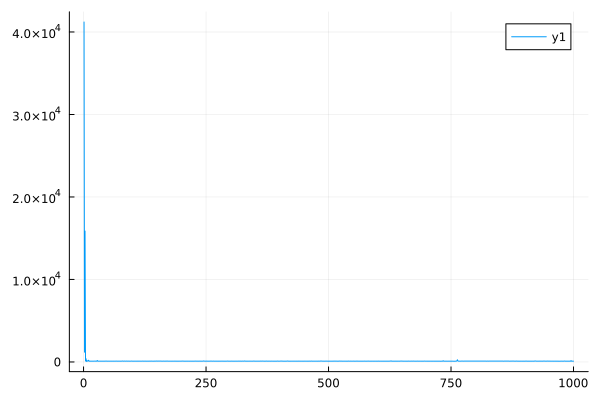

In [7]:
plot(epoch_percent_loss_vec)

In [ ]:
#! The model doesn't start with any thermodynamic knowledge. Is there any database we could pre-train on?

In [ ]:
# Plot epoch loss vectors